# Practicum 3 Power Flow After Installing PV Panels

In [1]:
import json
import math
from copy import deepcopy
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import power_grid_model as pgm
import pandas as pd
from power_grid_model import initialize_array, PowerGridModel, ComponentType, DatasetType, CalculationType
from power_grid_model.utils import json_deserialize
from power_grid_model.validation import assert_valid_batch_data
from matplotlib.gridspec import GridSpec

from plot_utils.plot import plot_power_grid

## Read PV Panel Area and Irradiance Data

Below is a summary of the nodes where the PV panels
can be installed, along with the maximum available area of the panels. These areas are highlighted in the map image `grid_map.jpg`.
| Node | Area (m^2) |
| ---  | --- |
| 1 | 2005 |
| 2 | 7019 |
| 5 | 8421 |
| 9 | 39832 |
| 13 | 2137 |
| 18 | 4289 |
| 23 | 9480 |
| 26 | 4605 |
| 35 | 2002 |


In [2]:
with open("data/pv_panel_area.json", "r") as f:
    pv_area = json.load(f)  # unit: m^2
pv_area

{'version': '1.0',
 'data': [{'node': 1, 'area': 2005},
  {'node': 2, 'area': 7019},
  {'node': 5, 'area': 8421},
  {'node': 7, 'area': 14044},
  {'node': 9, 'area': 39832},
  {'node': 13, 'area': 2137},
  {'node': 18, 'area': 4289},
  {'node': 23, 'area': 9480},
  {'node': 26, 'area': 4605},
  {'node': 35, 'area': 2002}]}

In [3]:
# get irradiance of a full week in June 2022, in 15-minute intervals
irradiance = np.load("data/bijmer_arena_irradiance_week.npy")  # unit: W/m^2

Text(0, 0.5, 'Irradiance (W/m^2)')

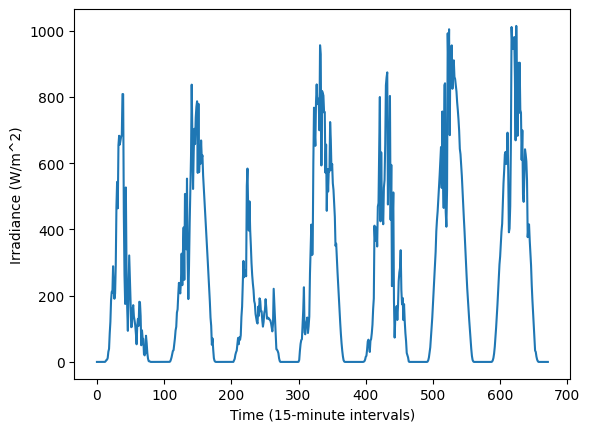

In [4]:
plt.plot(irradiance, label="Irradiance (W/m^2)")
plt.xlabel("Time (15-minute intervals)")
plt.ylabel("Irradiance (W/m^2)")

## Calculate the Power Generated by PV Panels

In [ ]:
pv_power_time_series = []
for panel in pv_area["data"]:
    panel_node = panel["node"]

    power =  # TODO
    pv_power_time_series.append({
        "node": np.full_like(irradiance.shape, panel_node),
        "p": power,  # assume PF = 1.0
    })

Text(0, 0.5, 'Power (W)')

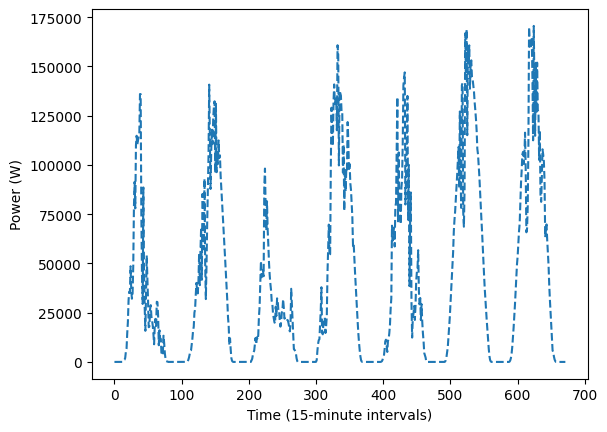

In [6]:
# visualize one panel
plt.plot(pv_power_time_series[-1]["p"], label="PV Power (W)", linestyle="--")
plt.xlabel("Time (15-minute intervals)")
plt.ylabel("Power (W)")

## Read Grid Data and Update with PV Power

### Read Grid Data and Baseload Data

In [8]:
# load grid
with open("data/arena_raw_data_65.json") as fp:
    data = fp.read()
dataset = json_deserialize(data)

# load base load
df_base_load = pd.read_csv("data/processed/transformer_data_week.csv")
base_load = df_base_load[df_base_load.columns[1:]].to_numpy()  # (672, 39)
base_load_array = initialize_array(
    DatasetType.update,
    ComponentType.sym_load,
    base_load.shape,  # (672, 39)
)
base_load_array["id"] = [dataset["sym_load"]["id"].tolist()]
base_load_array["p_specified"] = base_load * 1e3
base_load_array["q_specified"] = base_load * 1e3 * 0.4843  # PF = 0.9


### Update the Load Data with PV

In [ ]:
# create a new array for baseload + pv
load_profile_array = deepcopy(base_load_array)
node_ids = dataset["node"]["id"][:-1]  # Shape: (39,)

# build a map from node ID to column index
node_to_col_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}
# modify the baseload based on PV power
for pv_data in pv_power_time_series:
    pv_node_id = pv_data["node"][0]
    
    # Find the column index for this node
    if pv_node_id in node_to_col_idx:
        col_idx = node_to_col_idx[pv_node_id]
        
        # Subtract PV power from load power
        load_profile_array["p_specified"][:, col_idx] =  # TODO: modify the power based on the PV output

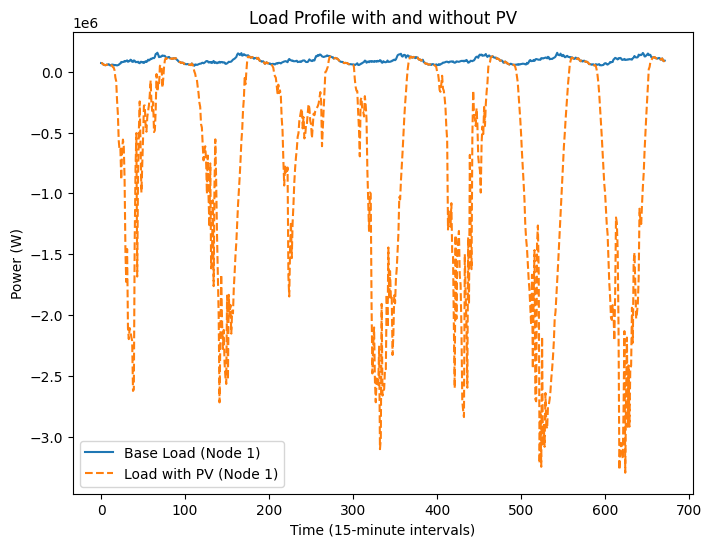

In [ ]:
# visualize the load profile with and without PV
plt.figure(figsize=(8, 6))
# plot `base_load_array` and `load_profile_array` for an arbitrary node for the whole week.
# TODO

plt.xlabel("Time (15-minute intervals)")
plt.ylabel("Power (W)")
plt.title("Load Profile with and without PV")
plt.legend()
plt.show()

## Calculate the Power Flow

In [ ]:
time_series_mutation = {
    ComponentType.sym_load: load_profile_array,
}
assert_valid_batch_data(input_data=dataset, update_data=time_series_mutation,
                        calculation_type=CalculationType.power_flow)

model = PowerGridModel(dataset)
output_data = model.calculate_power_flow(
    update_data=time_series_mutation,
)

### Plot Voltage

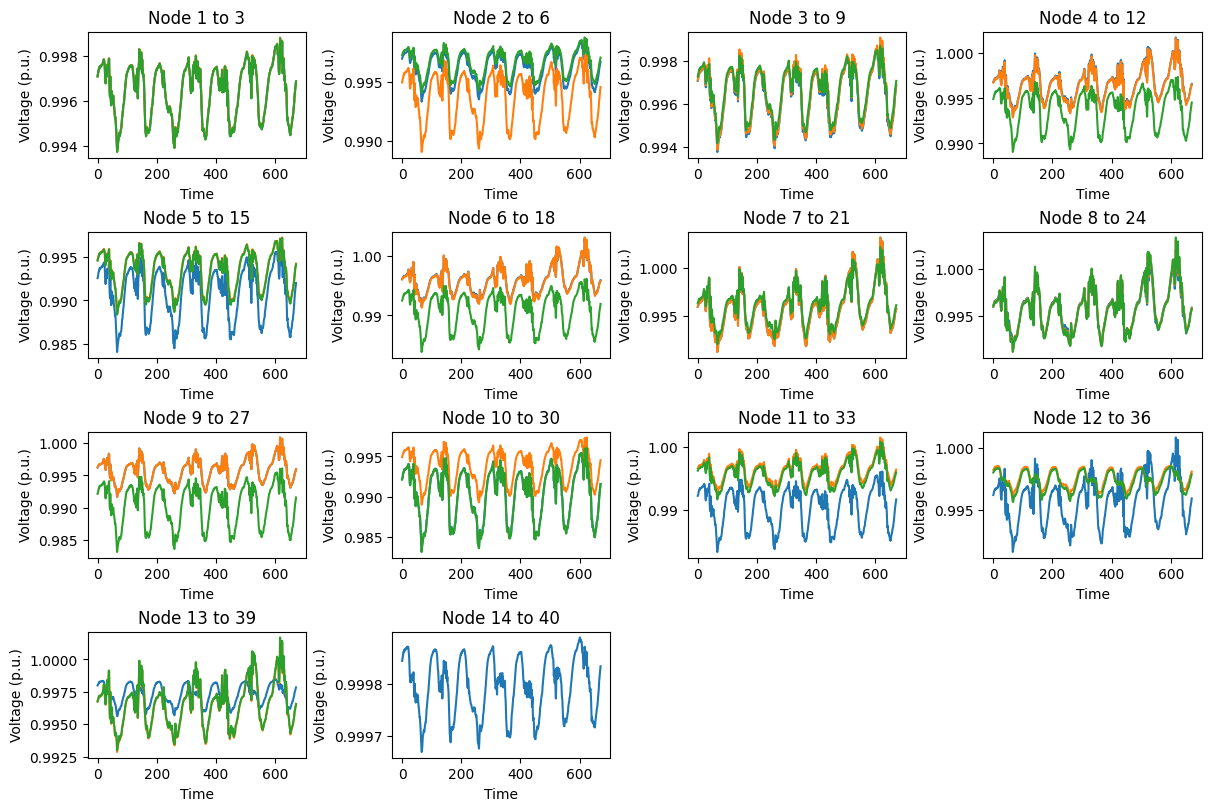

In [ ]:
# plot u_pu of each node over time
# TODO

### Plot Line Loadings

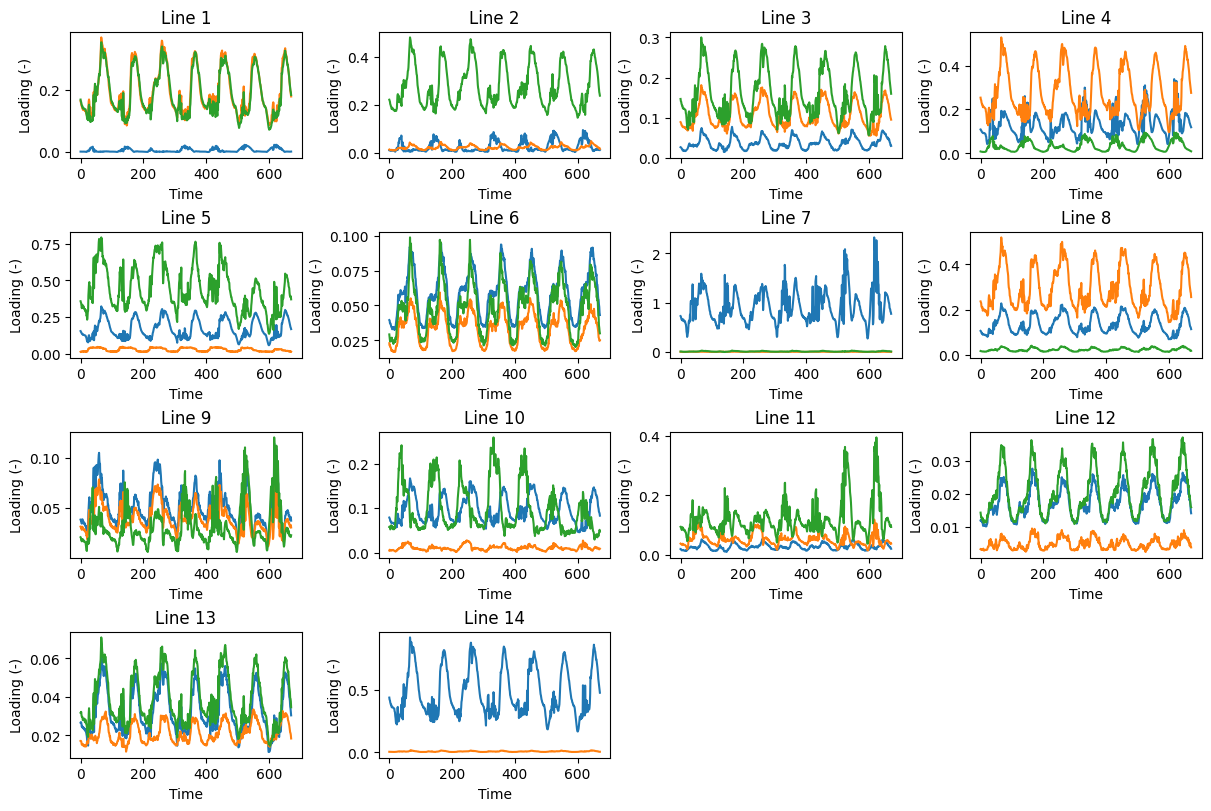

In [ ]:
# plot loading of each line over time
# TODO

### Visualize in Graph

In [ ]:
graph = nx.Graph()
graph.add_nodes_from(
    output_data[ComponentType.node]["id"][0],
)
graph.add_edges_from(
    zip(dataset[ComponentType.line]["from_node"], dataset[ComponentType.line]["to_node"]),
)
graph.add_edges_from(
    zip(dataset[ComponentType.transformer]["from_node"], dataset[ComponentType.transformer]["to_node"]),
)

pos=nx.spring_layout(graph, k=1.0, seed=43)

def visualize_snapshot(timestep: int) -> None:
    snapshot_node =  # TODO
    snapshot_line =  # TODO
    snapshot_transformer =  # TODO

    node_voltages = {_node["id"]: _node["u_pu"] for _node in snapshot_node}
    edge_loadings = {(_line_input["from_node"], _line_input["to_node"]): _line["loading"]
            for _line_input, _line in zip(dataset[ComponentType.line], snapshot_line)}
    edge_loadings.update({
        (_transformer_input["from_node"], _transformer_input["to_node"]): _transformer["loading"]
        for _transformer_input, _transformer in zip(dataset[ComponentType.transformer], snapshot_transformer)
    })
    for _node in snapshot_node:
        graph.nodes[_node["id"]]["voltage"] = _node["u_pu"]
    for _edge_from_to, _edge_loading in edge_loadings.items():
        graph.edges[_edge_from_to]["loading"] = _edge_loading

    fig, ax = plot_power_grid(
            graph,
            voltage_display='color',
            voltage_cmap="seismic",
            loading_display='color',
            loading_cmap="inferno_r",
            figsize=(10, 8),
            node_size=500,
            edge_width=3,
            font_size=10,
            loading_vmax=2,
            show_node_types=True,
            pos=pos,
        )

    plt.title('Power Grid Visualization')
    plt.show()

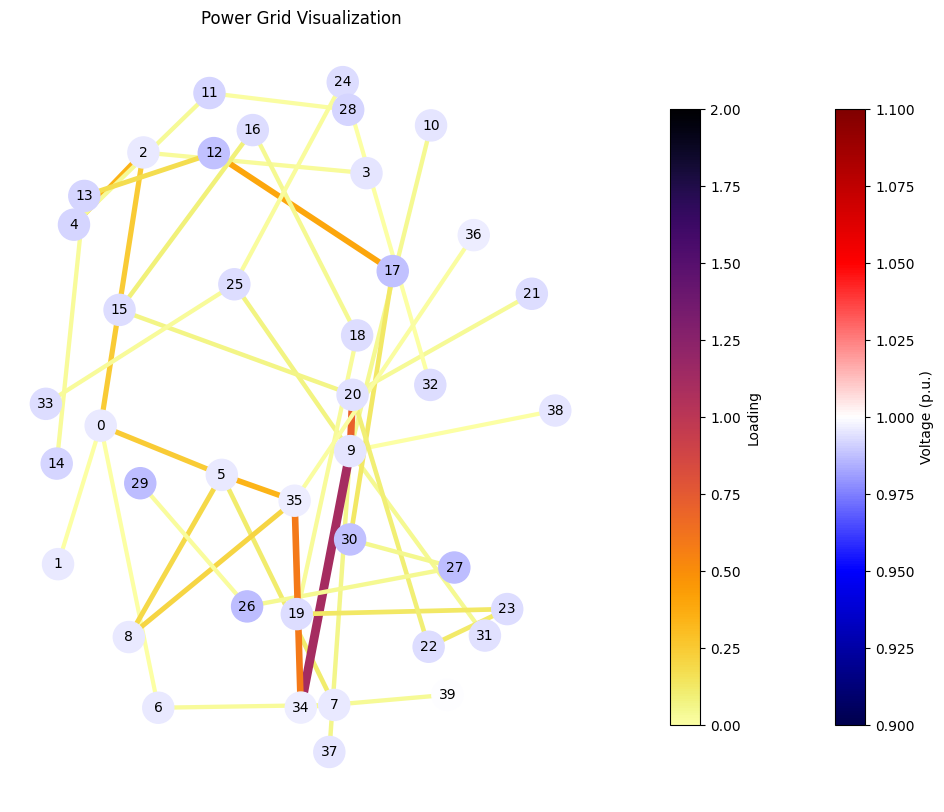

In [20]:
visualize_snapshot(timestep=250)

In [ ]:
# use a slider
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

# Create a slider
slider = widgets.IntSlider(
    value=100,
    min=0,
    max=671,
    step=1,
    description='Timestep:',
    continuous_update=True,
)

interact(visualize_snapshot, timestep=slider)

interactive(children=(IntSlider(value=100, description='Timestep:', max=671), Output()), _dom_classes=('widget…

<function __main__.visualize_snapshot(timestep: int) -> None>